In [92]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate

dataset_name = "cic-iot"
sample_size = 100000

# Load dateset
df = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2.csv')

# Split dataset according to attack type
normal_df = df[df['label'] == 'BenignTraffic']
attack_df = df[df['label'] != 'BenignTraffic']

# Drop columns
normal_df = normal_df.drop(columns=['label'])
attack_df = attack_df.drop(columns=['label'])

# Split dataset into training and test set
normal_df_train = normal_df.sample(frac=0.8, random_state=42)
normal_df_test = normal_df.drop(normal_df_train.index)
attack_df_train = attack_df.sample(frac=0.8, random_state=42)
attack_df_test = attack_df.drop(attack_df_train.index)

# Print dataset sizes in a table
data = [
    ["Normal", normal_df.shape[0], normal_df_train.shape[0], normal_df_test.shape[0]],
    ["Attack", attack_df.shape[0], attack_df_train.shape[0], attack_df_test.shape[0]]
]
print(tabulate(data, headers=["Attack type", "Total", "Train", "Test"], tablefmt="grid"))

+---------------+---------+---------+--------+
| Attack type   |   Total |   Train |   Test |
+===============+=========+=========+========+
| Normal        |   10800 |    8640 |   2160 |
+---------------+---------+---------+--------+
| Attack        |   89200 |   71360 |  17840 |
+---------------+---------+---------+--------+


In [93]:
################################################################################
# Vector Store
################################################################################

import json
import numpy as np
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

train_set_size = sample_size
n_results = 10
embeddings = HuggingFaceEmbeddings()
vector_store = Chroma(
    collection_name=dataset_name,
    embedding_function=embeddings,
    persist_directory=f"./vector-stores/chroma-db-{train_set_size}-2")

normal_vectors = vector_store._collection.get(include=['embeddings'], where={'label': 'normal'})['embeddings']
normal_mean_vector = np.mean(normal_vectors, axis=0).tolist()
normal_documents = \
    vector_store._collection.query(query_embeddings=[normal_mean_vector], n_results=n_results)['documents'][0]

attack_vectors = vector_store._collection.get(include=['embeddings'], where={'label': 'attack'})['embeddings']
attack_mean_vector = np.mean(attack_vectors, axis=0).tolist()
attack_documents = \
    vector_store._collection.query(query_embeddings=[attack_mean_vector], n_results=n_results)['documents'][0]

normal_entries_dict = {}
for i, feature_name in enumerate(normal_df_train.columns.to_list()):
    normal_entries_dict[feature_name] = [json.loads(doc.replace("'", "\""))[i] for doc in normal_documents]

attack_entries_dict = {}
for i, feature_name in enumerate(attack_df_train.columns.to_list()):
    attack_entries_dict[feature_name] = [json.loads(doc.replace("'", "\""))[i] for doc in attack_documents]

In [94]:
################################################################################
# State
################################################################################

from langgraph.graph import MessagesState


class State(MessagesState):
    i: int
    max_f1s: float
    normal_entries: str
    attack_entries: str

In [95]:
################################################################################
# Tool Node
################################################################################

import operator
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from typing import Annotated
from langchain_core.tools import tool

show_progress = False
operations = {'<': operator.lt, '>': operator.gt, '==': operator.eq, '<=': operator.le, '>=': operator.ge,
              '!=': operator.ne}


@tool
def evaluation_tool(
        feature_name: Annotated[str, "Feature name"],
        value: Annotated[float, "Value"],
        op: Annotated[str, "Operator"]
) -> float:
    """Evaluate the rule and return the macro f1-score."""
    try:
        value = float(value)
    except ValueError:
        print("Value must be a number.")
    datasets = {"normal": normal_df_train, "attack": attack_df_train}
    y_pred = []
    y_true = []
    if op in operations:
        for attack_type, dataset in datasets.items():
            test_set_size = dataset.shape[0]
            for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries...",
                          disable=not show_progress):
                y_true.append(attack_type)
                y_pred.append("attack" if operations[op](dataset.iloc[i][feature_name], value) else "normal")
        c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
        return c_report['macro avg']['f1-score']
    else:
        raise ValueError(f"Unsupported operator: {op}")

In [115]:
################################################################################
# LLM Node
################################################################################

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
import dotenv
import os

dotenv.load_dotenv(os.getcwd() + '/../.env')
tools = [evaluation_tool]

# llm = ChatOpenAI(model="gpt-4o", temperature=0.1)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)

normal_entries = json.dumps(normal_entries_dict)
attack_entries = json.dumps(attack_entries_dict)


def llm_node(state):
    completion = llm_with_tools.invoke(state["messages"])
    return {"messages": [completion], "i": state["i"] + 1}

In [127]:
################################################################################
# Evaluate Node
################################################################################

from sklearn.metrics import classification_report, confusion_matrix
from statistics import mode
from tqdm import tqdm


def evaluate_node(state):
    ai_messages = [msg for msg in state["messages"] if isinstance(msg, AIMessage) and len(msg.tool_calls) > 0]
    if len(ai_messages) == 0:
        pass
    tool_calls = ai_messages[-1].tool_calls
    datasets = {"normal": normal_df_test, "attack": attack_df_test}
    y_pred = []
    y_true = []
    for attack_type, dataset in datasets.items():
        test_set_size = dataset.shape[0]
        for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries...",
                      disable=False):
            try:
                predicted_attack_types = []
                for tool_call in tool_calls:
                    args = tool_call["args"]
                    op = args["op"]
                    feature_name = args["feature_name"]
                    value = args["value"]
                    try:
                        value = float(value)
                    except ValueError:
                        value
                    predicted_attack_types.append(
                        "attack" if operations[op](dataset.iloc[i][feature_name], value) else "normal")
                y_true.append(attack_type)
                y_pred.append(mode(predicted_attack_types))
            except Exception as e:
                continue
    c_report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    c_matrix = confusion_matrix(y_true, y_pred)
    print(c_report)
    print(c_matrix)
    macro_f1s = c_report['macro avg']['f1-score']
    human_message = HumanMessage(f"""
    The current macro avg f1-score for the generated rules is {macro_f1s}.
    If this macro avg f1-score is greater than the maximum achieved so far {state["max_f1s"]},
    keep the better performing rules and revise or replace only the under performing ones.
    Otherwise, revise or replace any rules to maximize the f1-score.
    Based on the feedback, generate exactly {k} rules to filter attack entries and
    make a tool call for each rule, ensuring that a tool call is made for every entry every time.
    """)
    return {"messages": state["messages"] + [human_message], "max_f1s": max(state["max_f1s"], macro_f1s)}

In [98]:
################################################################################
# Conditional Edge for Tools
################################################################################

def tools_condition_edge(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "evaluate_node"

In [99]:
################################################################################
# Conditional Edge for Feedback
################################################################################

def feedback_condition_edge(state):
    if state["i"] < n:
        return "llm_node"
    return "__end__"

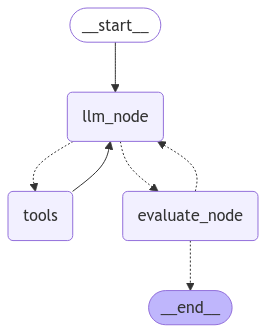

In [128]:
################################################################################
# Graph
################################################################################

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)

builder.add_node("llm_node", llm_node)
builder.add_node("tools", ToolNode(tools))
builder.add_node("evaluate_node", evaluate_node)

builder.add_edge(START, "llm_node")
builder.add_conditional_edges("llm_node", tools_condition_edge, ["tools", "evaluate_node"])
builder.add_edge("tools", "llm_node")
builder.add_conditional_edges("evaluate_node", feedback_condition_edge, ["llm_node", END])

memory_saver = MemorySaver()
graph = builder.compile(checkpointer=memory_saver)

display(Image(graph.get_graph().draw_mermaid_png()))

In [132]:
################################################################################
# Invoke Graph
################################################################################

k = 5
n = 10
system_message = SystemMessage(f"""
You are a good data analyst.
You are provided with network data entries categorized as either normal or attack, along with their corresponding feature names.
Carefully analyze the differences between normal and attack entries by comparing corresponding fields.
Your task is to generate {k} simple and deterministic rules for top {k} important features to filter attack entries.
Supported operators are '==', '!=', '>', '<', '>=', '<='.
Generate exactly {k} rules to filter attack entries and make a tool call for each rule.
After getting results output the rule as a message.
""")
human_message = HumanMessage(f"""
Analyze the following network data and generate rules for the top 5 important features to filter attack entries.

Normal Entries:
```{normal_entries}```

Attack Entries:
```{attack_entries}```
""")
state = State(i=0, max_f1s=0.5, normal_entries=json.dumps(normal_entries_dict),
              attack_entries=json.dumps(attack_entries_dict), messages=[system_message, human_message])
config = {"configurable": {"thread_id": 4}}

output = graph.invoke(state, config)

Predicting attack entries...: 100%|████████████████████████| 17840/17840 [00:01<00:00, 11343.50it/s]


{'attack': {'precision': 0.9960629921259843, 'recall': 0.02836322869955157, 'f1-score': 0.05515587529976019, 'support': 17840.0}, 'normal': {'precision': 0.1107120870100554, 'recall': 0.9990740740740741, 'f1-score': 0.19933493441714392, 'support': 2160.0}, 'accuracy': 0.1332, 'macro avg': {'precision': 0.5533875395680198, 'recall': 0.5137186513868128, 'f1-score': 0.12724540485845207, 'support': 20000.0}, 'weighted avg': {'precision': 0.9004450943734639, 'recall': 0.1332, 'f1-score': 0.07072721368443763, 'support': 20000.0}}
[[  506 17334]
 [    2  2158]]


Predicting attack entries...: 100%|████████████████████████| 17840/17840 [00:01<00:00, 11429.19it/s]


{'attack': {'precision': 0.9877533783783784, 'recall': 0.13110986547085202, 'f1-score': 0.23149247822644498, 'support': 17840.0}, 'normal': {'precision': 0.1208598003629764, 'recall': 0.986574074074074, 'f1-score': 0.21533953112368634, 'support': 2160.0}, 'accuracy': 0.2235, 'macro avg': {'precision': 0.5543065893706774, 'recall': 0.558841969772463, 'f1-score': 0.22341600467506567, 'support': 20000.0}, 'weighted avg': {'precision': 0.8941288719527148, 'recall': 0.2235, 'f1-score': 0.22974795993934705, 'support': 20000.0}}
[[ 2339 15501]
 [   29  2131]]


Predicting attack entries...: 100%|████████████████████████| 17840/17840 [00:01<00:00, 11974.17it/s]


{'attack': {'precision': 0.9993238166791886, 'recall': 0.7455717488789237, 'f1-score': 0.8539967897271268, 'support': 17840.0}, 'normal': {'precision': 0.32152466367713006, 'recall': 0.9958333333333333, 'f1-score': 0.48610169491525423, 'support': 2160.0}, 'accuracy': 0.7726, 'macro avg': {'precision': 0.6604242401781593, 'recall': 0.8707025411061285, 'f1-score': 0.6700492423211906, 'support': 20000.0}, 'weighted avg': {'precision': 0.9261215081549663, 'recall': 0.7726, 'f1-score': 0.8142641194874445, 'support': 20000.0}}
[[13301  4539]
 [    9  2151]]


Predicting attack entries...: 100%|████████████████████████| 17840/17840 [00:01<00:00, 12004.45it/s]


{'attack': {'precision': 0.9946501771694574, 'recall': 0.8024663677130045, 'f1-score': 0.8882821952657215, 'support': 17840.0}, 'normal': {'precision': 0.3714999108257535, 'recall': 0.9643518518518519, 'f1-score': 0.5363718295352131, 'support': 2160.0}, 'accuracy': 0.81995, 'macro avg': {'precision': 0.6830750439976054, 'recall': 0.8834091097824281, 'f1-score': 0.7123270124004673, 'support': 20000.0}, 'weighted avg': {'precision': 0.9273499484043374, 'recall': 0.81995, 'f1-score': 0.8502758757668265, 'support': 20000.0}}
[[14316  3524]
 [   77  2083]]


In [133]:
for msg in output["messages"]:
    msg.pretty_print()

================================ System Message ================================


You are a good data analyst.
You are provided with network data entries categorized as either normal or attack, along with their corresponding feature names.
Carefully analyze the differences between normal and attack entries by comparing corresponding fields.
Your task is to generate 5 simple and deterministic rules for top 5 important features to filter attack entries.
Supported operators are '==', '!=', '>', '<', '>=', '<='.
Generate exactly 5 rules to filter attack entries and make a tool call for each rule.
After getting results output the rule as a message.

================================ Human Message =================================


Analyze the following network data and generate rules for the top 5 important features to filter attack entries.

Normal Entries:
```{"flow_duration": [68.77084934711456, 13.5462904214859, 66.11528234481811, 79.71634311676026, 43.41688930988312, 44.06503100395203